In [85]:
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from dotenv import load_dotenv
import datetime as dt
import requests
#import json
import base64
import time
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn import tree
import fire
import pickle
import cbpro
from Historic_Crypto import HistoricalData

In [86]:
""" importing the cbpro library and assigning the public client """

public_client = cbpro.PublicClient()

In [87]:
""" loading the private client's api keys and secret keys """
load_dotenv()
api_key = os.getenv("COINBASE_SAND_API")
api_secret = os.getenv("COINBASE_SAND_SECRET")
api_passphrase = os.getenv("COINBASE_SAND_PASSPHRASE")



In [88]:
""" authorizing the api to interact with the sandbox"""

auth_client = cbpro.AuthenticatedClient(api_key, api_secret, api_passphrase,
                                  api_url="https://api-public.sandbox.pro.coinbase.com")

next is setting the buy and sell signals

In [89]:
""" importing historic crypto to fecth the historical data for the trading strategies and model """


btc_hist_data = HistoricalData('BTC-USD',86400,'2017-01-01-00-00').retrieve_data()

Checking input parameters are in the correct format...
Formatting Dates...
Checking if ticker supplied is available on the CoinBase Pro API...
Connected to the CoinBase Pro API...
Ticker 'BTC-USD' found at the CoinBase Pro API, continuing to extraction...
Data for chunk 0 of 5 extracted
Data for chunk 1 of 5 extracted
Data for chunk 2 of 5 extracted
Data for chunk 3 of 5 extracted
Data for chunk 4 of 5 extracted
Data for chunk 5 of 5 extracted


In [90]:
""" printing out the historical data and writing to .csv file """
btc_hist_data.to_csv('btc_hist_data.csv')
btc_hist_data

,low,high,open,close,volume
time,,,,,
2017-01-02,990.52,1034.39,992.96,1011.45,7723.635752
2017-01-03,1006.71,1036.99,1011.52,1020.67,8615.260058
2017-01-04,1018.00,1147.00,1020.69,1130.30,16222.230267
2017-01-05,880.00,1175.00,1131.10,1007.00,20446.405615
2017-01-06,875.01,1033.85,1007.00,895.71,14274.259206
...,...,...,...,...,...
2021-10-19,61333.00,64500.00,62042.40,64303.14,17380.304862
2021-10-20,63525.00,66999.00,64303.14,66026.54,19194.454109
2021-10-21,62050.00,66650.85,66021.26,62204.02,23474.391333


In [91]:
""" creating a signals dataframe to hold the values of the actual returns """

signals_df = btc_hist_data.loc[:, ["close"]]

signals_df["Actual Returns"] = btc_hist_data["close"].pct_change()

signals_df = signals_df.dropna()

display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns
time,,
2017-01-03,1020.67,0.009116
2017-01-04,1130.30,0.107410
2017-01-05,1007.00,-0.109086
2017-01-06,895.71,-0.110516
2017-01-07,909.00,0.014837


,close,Actual Returns
time,,
2021-10-19,64303.14,0.036438
2021-10-20,66026.54,0.026801
2021-10-21,62204.02,-0.057894
2021-10-22,60687.64,-0.024378
2021-10-23,60985.33,0.004905


utc translation or conversion there should be a library utc conversioin

In [92]:
""" setting the rolling windows for the long and short positions"""

short_window = 4
long_window = 8

signals_df['SMA_Fast'] = btc_hist_data['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = btc_hist_data['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow
time,,,,
2017-01-09,902.66,-0.022386,907.6750,975.01500
2017-01-10,907.00,0.004808,910.4975,961.95875
2017-01-11,795.77,-0.122635,882.1900,933.84625
2017-01-12,812.25,0.020710,854.4200,894.09000
2017-01-13,831.42,0.023601,836.6100,872.14250


,close,Actual Returns,SMA_Fast,SMA_Slow
time,,,,
2021-10-19,64303.14,0.036438,62187.5200,60147.17500
2021-10-20,66026.54,0.026801,63474.8000,61399.85500
2021-10-21,62204.02,-0.057894,63644.0275,62004.44250
2021-10-22,60687.64,-0.024378,63305.3350,62420.45875
2021-10-23,60985.33,0.004905,62475.8825,62331.70125


In [93]:
signals_df['Signal'] = 0.0

"""creating the buy signal"""
signals_df.loc[(signals_df['Actual Returns'] < -0.01), 'Signal'] = 1

"""creating the sell signal"""
signals_df.loc[(signals_df['Actual Returns'] > 0.05), 'Signal'] = -1

signals_df.loc[(signals_df['Actual Returns'] == 0.0), 'Signal'] = 0

""" creating the hold signal"""
#signals_df.loc[(signals_df['Actual Returns'] > -0.01) and (signals_df['Actual Returns'] < 0.02), 'Signal'] = 0

' creating the hold signal'

In [94]:
signals_df = signals_df.dropna()
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
time,,,,,
2017-01-09,902.66,-0.022386,907.6750,975.01500,1.0
2017-01-10,907.00,0.004808,910.4975,961.95875,0.0
2017-01-11,795.77,-0.122635,882.1900,933.84625,1.0
2017-01-12,812.25,0.020710,854.4200,894.09000,0.0
2017-01-13,831.42,0.023601,836.6100,872.14250,0.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
time,,,,,
2021-10-19,64303.14,0.036438,62187.5200,60147.17500,0.0
2021-10-20,66026.54,0.026801,63474.8000,61399.85500,0.0
2021-10-21,62204.02,-0.057894,63644.0275,62004.44250,1.0
2021-10-22,60687.64,-0.024378,63305.3350,62420.45875,1.0
2021-10-23,60985.33,0.004905,62475.8825,62331.70125,0.0


In [95]:
""" creating a new dataframe to hold the signals data"""
"""
signals_df["Signal"] = 0.0

signals_df['Signal'][short_window:] = np.where(
    signals_df['SMA_Fast'][short_window:] > signals_df['SMA_Slow'][short_window:], 1.0, 0.0
)

signals_df = signals_df.dropna()
display(signals_df.head())
display(signals_df.tail())
"""


'\nsignals_df["Signal"] = 0.0\n\nsignals_df[\'Signal\'][short_window:] = np.where(\n    signals_df[\'SMA_Fast\'][short_window:] > signals_df[\'SMA_Slow\'][short_window:], 1.0, 0.0\n)\n\nsignals_df = signals_df.dropna()\ndisplay(signals_df.head())\ndisplay(signals_df.tail())\n'

In [96]:
""" creating entry exit columns for the plot"""
signals_df['Entry/Exit'] = signals_df['Signal'].diff()

In [97]:
""" creating a plot to visualize the trades"""

exit = signals_df[signals_df['Entry/Exit'] == -1.0]['close'].hvplot.scatter(
    color='yellow',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)


entry = signals_df[signals_df['Entry/Exit'] == 1.0]['close'].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)


security_close = signals_df[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)


moving_avgs = signals_df[['SMA_Slow', 'SMA_Fast']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)


entry_exit_plot = security_close * moving_avgs * entry * exit


entry_exit_plot.opts(
    title="Bitcoin - SMASlow, SMAFast, Entry and Exit Points"
)

:Overlay
   .Curve.I          :Curve   [time]   (close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [time]   (value)
   .Scatter.Close.I  :Scatter   [time]   (close)
   .Scatter.Close.II :Scatter   [time]   (close)

In [98]:
""" writing the signals df to .csv"""
signals_df.to_csv("signals.csv")

In [99]:
""" evaluating the balance of the signals"""
signals_df['Signal'].value_counts()

 0.0    1043
 1.0     533
-1.0     173
Name: Signal, dtype: int64

In [100]:
""" creating a strategy returns colums to hold the returns data using the signals
programmed in the code
"""
signals_df['Actual Returns'] = signals_df['close'].pct_change()
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Entry/Exit,Strategy Returns
time,,,,,,,
2017-01-09,902.66,NaN,907.6750,975.01500,1.0,NaN,NaN
2017-01-10,907.00,0.004808,910.4975,961.95875,0.0,-1.0,0.004808
2017-01-11,795.77,-0.122635,882.1900,933.84625,1.0,1.0,-0.000000
2017-01-12,812.25,0.020710,854.4200,894.09000,0.0,-1.0,0.020710
2017-01-13,831.42,0.023601,836.6100,872.14250,0.0,0.0,0.000000


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Entry/Exit,Strategy Returns
time,,,,,,,
2021-10-19,64303.14,0.036438,62187.5200,60147.17500,0.0,0.0,0.000000
2021-10-20,66026.54,0.026801,63474.8000,61399.85500,0.0,0.0,0.000000
2021-10-21,62204.02,-0.057894,63644.0275,62004.44250,1.0,1.0,-0.000000
2021-10-22,60687.64,-0.024378,63305.3350,62420.45875,1.0,0.0,-0.024378
2021-10-23,60985.33,0.004905,62475.8825,62331.70125,0.0,-1.0,0.004905


In [101]:
""" plotting the candlestick data with the entry and exit points """
                             
fig = go.Figure(data=[go.Candlestick(x = btc_hist_data.index,
                                    open = btc_hist_data['open'],
                                    high = btc_hist_data['high'],
                                    low = btc_hist_data['low'],
                                    close = btc_hist_data['close'],
                                    ),
                     go.Scatter(x=signals_df.index, y=signals_df['SMA_Fast'], line=dict(color='purple', width=1)),
                     go.Scatter(x=signals_df.index, y=signals_df['SMA_Slow'], line=dict(color='green', width=1))])
                     


fig.show()


<AxesSubplot:title={'center':'Bitcoin Cumulative Returns'}, xlabel='time'>

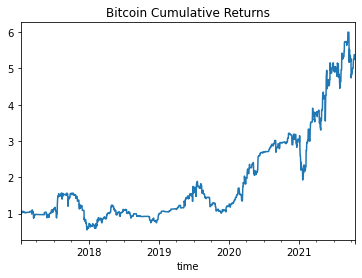

In [102]:
""" plotting the strategy returns to better see the data """

(1 + signals_df['Strategy Returns']).cumprod().plot(x="date", title="Bitcoin Cumulative Returns")

Here we start the backtesting

In [103]:
""" simple backtesting using cumulative returns and $100,000"""

initial_capital = float(100000)
btc_quantity = 1

signals_df['Position'] = btc_quantity * signals_df['Signal']
signals_df['Entry/Exit Position'] = signals_df['Position'].diff()
signals_df['Portfolio Holdings'] = signals_df['close'] * signals_df['Position']
signals_df['Portfolio Cash'] = initial_capital - (signals_df['close'] * signals_df['Entry/Exit Position']).cumsum()
signals_df['Portfolio Total'] = signals_df['Portfolio Cash'] + signals_df['Portfolio Holdings']
signals_df['Portfolio Daily Returns'] = signals_df['Portfolio Total'].pct_change()
signals_df['Portfolio Cumulative Returns'] = (1 + signals_df['Portfolio Daily Returns']).cumprod() - 1
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Entry/Exit,Strategy Returns,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
time,,,,,,,,,,,,,,
2017-01-09,902.66,NaN,907.6750,975.01500,1.0,NaN,NaN,1.0,NaN,902.66,NaN,NaN,NaN,NaN
2017-01-10,907.00,0.004808,910.4975,961.95875,0.0,-1.0,0.004808,0.0,-1.0,0.00,100907.00,100907.00,NaN,NaN
2017-01-11,795.77,-0.122635,882.1900,933.84625,1.0,1.0,-0.000000,1.0,1.0,795.77,100111.23,100907.00,0.000000,0.000000
2017-01-12,812.25,0.020710,854.4200,894.09000,0.0,-1.0,0.020710,0.0,-1.0,0.00,100923.48,100923.48,0.000163,0.000163
2017-01-13,831.42,0.023601,836.6100,872.14250,0.0,0.0,0.000000,0.0,0.0,0.00,100923.48,100923.48,0.000000,0.000163


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Entry/Exit,Strategy Returns,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
time,,,,,,,,,,,,,,
2021-10-19,64303.14,0.036438,62187.5200,60147.17500,0.0,0.0,0.000000,0.0,0.0,0.00,136237.56,136237.56,0.000000e+00,0.350130
2021-10-20,66026.54,0.026801,63474.8000,61399.85500,0.0,0.0,0.000000,0.0,0.0,0.00,136237.56,136237.56,0.000000e+00,0.350130
2021-10-21,62204.02,-0.057894,63644.0275,62004.44250,1.0,1.0,-0.000000,1.0,1.0,62204.02,74033.54,136237.56,-2.220446e-16,0.350130
2021-10-22,60687.64,-0.024378,63305.3350,62420.45875,1.0,0.0,-0.024378,1.0,0.0,60687.64,74033.54,134721.18,-1.113041e-02,0.335102
2021-10-23,60985.33,0.004905,62475.8825,62331.70125,0.0,-1.0,0.004905,0.0,-1.0,0.00,135018.87,135018.87,2.209675e-03,0.338053


HERE WE START THE MACHINE LEARNING MODEL

In [104]:
""" creating an X features dataframe to split the data into training and testing data"""

X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().copy().dropna()
X.head()

,SMA_Fast,SMA_Slow
time,,
2017-01-10,907.6750,975.01500
2017-01-11,910.4975,961.95875
2017-01-12,882.1900,933.84625
2017-01-13,854.4200,894.09000
2017-01-14,836.6100,872.14250


In [105]:
signals_df['Signal'] = 0.0

"""creating the buy signal"""
signals_df.loc[(signals_df['Actual Returns'] < -0.01), 'Signal'] = 1

"""creating the sell signal"""
signals_df.loc[(signals_df['Actual Returns'] > 0.05), 'Signal'] = -1

signals_df.loc[(signals_df['Actual Returns'] == 0.0), 'Signal'] = 0

In [106]:
""" creating a signals df to hold the X and y data for the ML model"""
"""
signals_df['Signal'] = 0.0

creating the buy signal
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

creating the sell signal
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1
"""

"\nsignals_df['Signal'] = 0.0\n\ncreating the buy signal\nsignals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1\n\ncreating the sell signal\nsignals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1\n"

In [107]:
""" copying the signal data to the y variable"""
y = signals_df['Signal'].copy().dropna()

In [108]:
""" checking the value counts """

y.value_counts()

 0.0    1044
 1.0     532
-1.0     173
Name: Signal, dtype: int64

In [109]:
X

,SMA_Fast,SMA_Slow
time,,
2017-01-10,907.6750,975.01500
2017-01-11,910.4975,961.95875
2017-01-12,882.1900,933.84625
2017-01-13,854.4200,894.09000
2017-01-14,836.6100,872.14250
...,...,...
2021-10-19,61535.5825,59295.21250
2021-10-20,62187.5200,60147.17500
2021-10-21,63474.8000,61399.85500


In [110]:
""" telling the algorithm when to start the training data """
training_begin = X.index.min()
print(training_begin)

2017-01-10 00:00:00


In [111]:
""" telling the algorithm when to end the training data """
training_end = X.index.min() + DateOffset(years=1)

print(training_end)

2018-01-10 00:00:00


In [112]:
""" creating new training dataframes using the start/end data"""
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

In [113]:
""" creating new testing dataframes using the start/end data"""
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

In [114]:
""" checking the numbers """
X_test.shape

(1383, 2)

In [115]:
""" scaling the X data using StandardScaler instance """

scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

""" resampling the data for better predictions X is overbalanced"""

ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)


In [116]:
""" best so far using the DecisionTree Classifier to train and predict trading signals """


model = tree.DecisionTreeClassifier(random_state=3, max_depth=None, splitter='best')
 
model = model.fit(X_resampled, y_resampled)
 
pred = model.predict(X_resampled)

pred


array([ 0.,  1.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,
        1.,  1.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., -1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  1.,  1.,  0.,  1., -1.,  0.,  0.,  0.,  0.,
        1.,  1.,  1., -1.,  0., -1.,  1.,  0.,  1.,  0.,  0., -1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., -1.,  0.,  0.,  0.,  1., -1.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., -1., -1.,  1.,  1.,  1., -1.,  0.,  1., -1., -1.,
        0.,  0.,  1., -1., -1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
        0.,  0., -1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1., -1.,
        0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1

In [117]:
""" creating an SVM model to backtest the data keeping this in case I need it"""
"""
model = svm.SVC()
 
model = model.fit(X_resampled, y_resampled)
 
pred = model.predict(X_resampled)

pred
"""

'\nmodel = svm.SVC()\n \nmodel = model.fit(X_resampled, y_resampled)\n \npred = model.predict(X_resampled)\n\npred\n'

In [118]:
""" creating a classification report to see the model's training performance """
testing_report = classification_report(y_resampled, pred)

print(testing_report)

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       214
         0.0       1.00      1.00      1.00       214
         1.0       1.00      1.00      1.00       214

    accuracy                           1.00       642
   macro avg       1.00      1.00      1.00       642
weighted avg       1.00      1.00      1.00       642



Backesting the SVM Resampled Model

In [119]:
""" creating a testing report to see how my model performed with test data"""

testing_signal_predictions = model.predict(X_test_scaled)
testing_report = classification_report(y_test, testing_signal_predictions)
print(testing_report)

              precision    recall  f1-score   support

        -1.0       0.07      0.24      0.11       119
         0.0       0.63      0.36      0.45       830
         1.0       0.35      0.41      0.38       434

    accuracy                           0.36      1383
   macro avg       0.35      0.34      0.31      1383
weighted avg       0.49      0.36      0.40      1383



In [120]:
""" creating a new dataframe to hold the predictions of y using the X_test data 
We are using the actual and predicted returns to calculate the strategy returns
"""

predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["Predicted Signal"] = testing_signal_predictions

predictions_df["Actual Returns"] = signals_df["Actual Returns"]

predictions_df["Trading Algorithm Returns"] = (
    predictions_df["Actual Returns"] * predictions_df["Predicted Signal"]
)


display(predictions_df.head())
display(predictions_df.tail())

,Predicted Signal,Actual Returns,Trading Algorithm Returns
time,,,
2018-01-10,0.0,0.027221,0.000000
2018-01-11,1.0,-0.105351,-0.105351
2018-01-12,1.0,0.038468,0.038468
2018-01-13,1.0,0.026624,0.026624
2018-01-14,1.0,-0.037477,-0.037477


,Predicted Signal,Actual Returns,Trading Algorithm Returns
time,,,
2021-10-19,1.0,0.036438,0.036438
2021-10-20,1.0,0.026801,0.026801
2021-10-21,1.0,-0.057894,-0.057894
2021-10-22,1.0,-0.024378,-0.024378
2021-10-23,1.0,0.004905,0.004905


In [121]:
predictions_df["Trading Algorithm Returns"].value_counts()

 0.000000    467
 0.002406      1
-0.010197      1
 0.001542      1
 0.068997      1
            ... 
 0.021374      1
-0.003895      1
 0.007344      1
-0.019281      1
 0.076797      1
Name: Trading Algorithm Returns, Length: 917, dtype: int64

predictions_df.sample(10)

<AxesSubplot:xlabel='time'>

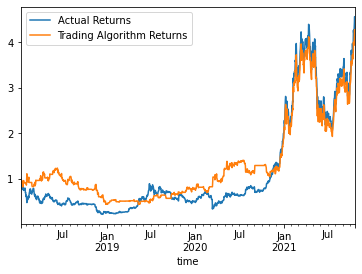

In [122]:
""" plotting the actual returns vs the strategy returns to analyse the performance of the model"""


(1 + predictions_df[["Actual Returns", "Trading Algorithm Returns"]]).cumprod().plot()

In [123]:
""" saving model for later use """
import pickle
filename = 'bitcoin_tree.sav'
pickle.dump(model, open(filename, 'wb'))

CREATING AN EXECUTION FUNCTION FOR TRADES

In [124]:
""" buy order btc from usd """
def buy():
    auth_client.buy(size='1', #BTC
        order_type='market',
        product_id='BTC-USD')

""" sell order btc to usd """

def sell():
    auth_client.sell(size='1', #BTC
        order_type='market',
        product_id='BTC-USD')


In [125]:
predictions_df

,Predicted Signal,Actual Returns,Trading Algorithm Returns
time,,,
2018-01-10,0.0,0.027221,0.000000
2018-01-11,1.0,-0.105351,-0.105351
2018-01-12,1.0,0.038468,0.038468
2018-01-13,1.0,0.026624,0.026624
2018-01-14,1.0,-0.037477,-0.037477
...,...,...,...
2021-10-19,1.0,0.036438,0.036438
2021-10-20,1.0,0.026801,0.026801
2021-10-21,1.0,-0.057894,-0.057894


In [126]:
""" have to create a for loop look through each colums .apply(write if statement)
I am still working on this.  This function will execute the live trade on sandbox"""
import fire

#df_prev = predictions_df["Predicted Signal"].shift()
def run():
  for index, row in predictions_df.iterrows():
    if (row['Predicted Signal'] == 1):
      print('buy')
    
    elif (row['Predicted Signal'] == -1.0):
      print('sell')
    
  #elif (row['Predicted Signal'] == row['Predicted Signal'].eq(row['Predicted Signal'].shift())):
    #print('hold')

    elif (row['Predicted Signal'] == 0.0):
      print('hold')


if __name__ == "__main__":
  fire.Fire(run)

""" I am trying to get the bot to hold if the signal is the same from the previous row"""

hold
buy
buy
buy
buy
hold
hold
sell
sell
sell
sell
sell
sell
sell
sell
hold
hold
hold
hold
hold
hold
hold
hold
hold
sell
sell
sell
sell
hold
hold
sell
sell
sell
hold
sell
sell
hold
hold
hold
hold
hold
hold
hold
hold
hold
hold
hold
sell
sell
hold
hold
hold
hold
hold
hold
sell
hold
hold
hold
sell
sell
sell
sell
sell
sell
hold
hold
hold
hold
hold
hold
hold
hold
hold
hold
hold
hold
hold
hold
sell
hold
buy
buy
buy
buy
buy
buy
buy
buy
buy
buy
buy
buy
buy
buy
hold
buy
buy
hold
buy
sell
sell
hold
hold
hold
hold
hold
hold
hold
hold
hold
sell
sell
sell
sell
sell
sell
sell
sell
sell
sell
sell
sell
hold
hold
hold
hold
hold
hold
hold
hold
hold
hold
sell
sell
sell
hold
buy
buy
buy
buy
buy
buy
buy
buy
buy
buy
buy
buy
buy
hold
hold
buy
buy
buy
buy
buy
sell
sell
sell
sell
hold
hold
hold
sell
hold
sell
sell
sell
sell
sell
sell
sell
sell
hold
sell
sell
sell
sell
hold
hold
hold
hold
sell
hold
sell
sell
sell
hold
hold
hold
buy
hold
hold
buy
buy
buy
hold
hold
buy
buy
sell
sell
sell
sell
hold
hold
buy
buy
bu

ERROR: Could not consume arg: --ip=127.0.0.1
Usage: ipykernel_launcher.py

For detailed information on this command, run:
  ipykernel_launcher.py --help


FireExit: 2

/Users/juliannamilin/opt/anaconda3/envs/dev/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3445: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.

